# Compressive sensing example


In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch import fft, ifft, irfft, rfft
#from models import *
#from utils.denoising_utils import *

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs", torch.cuda.device_count())
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def fft_circulant(x, t): 
    # input length
    n = x.shape[-1]
    
    # reshape x
    x = x.unsqueeze(-1)
    x = torch.cat((x, torch.zeros(x.shape).type(dtype)), -1)
    
    # F^-1 x
    IFx = torch.ifft(x, 1, normalized=True)
    
    # Ft
    Ft = torch.fft(t, 1, normalized=True)

    # Diag(sqrt * Ft) F^-1 x
    IFx_c = torch.view_as_complex(IFx)
    Ft = torch.view_as_complex(Ft)
    DIFx = torch.view_as_real(np.sqrt(n) * IFx_c *  Ft)
    
    Cx = torch.fft(DIFx, 1, normalized=True)
    return Cx[:,0]

In [3]:
import scipy.fft
from scipy import linalg

def fft_circulant_np(x, t): 
    n = len(x)
    # step 1: F^{-1} @ x
    r1 = scipy.fft.ifft(x, norm='ortho')
    # step 2: Diag() @ F^{-1} @ x
    Ft = np.sqrt(n) * scipy.fft.fft(t, norm='ortho')
    r2 = r1 * Ft
    # step 3: F @ Diag() @ F^{-1} @ x
    return scipy.fft.fft(r2, norm='ortho')
# x = np.arange(8)
# t_np = t[:, 0].data.cpu().numpy()
# Cx = fft_circulant_np(x, t_np)
# print(x.shape, t_np.shape)
# print(Cx)
# print(Cx_var)

## Load example image

In [4]:
def crop_center(img, cropx, cropy):
    #y,x = img.shape
    y = img.shape[-2]
    x = img.shape[-1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    if len(img.shape) == 2:
        return img[starty:starty+cropy,startx:startx+cropx]
    if len(img.shape) == 3:
        return img[:,starty:starty+cropy,startx:startx+cropx]

path = './test_data/'
img_name = "art"
#img_path = path + "tomato_mri.jpg"
img_path = path + "art.jpeg"
# img_path = path + "rszkate.png"
# img_path = path + "astronaut_128.jpg"
# img_path = path + "girl_128.jpg"
# img_path = path + "sf4_rgb.png" 
#img_path = path + "grass.jpg"
# img_path = path + "phantom256.png"

img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

#img_np_small = np.array([crop_center(img_np[0], 128, 128)])
# img_np_small = crop_center(crop_center(img_np), 256, 256) # np.array([crop_center(img_np,256,256)])
img_np_small = crop_center(rgb2gray(img_np),128,128) # np.array([crop_center(img_np,256,256)])

# img_np_small = img_np
img_np_small = img_np_small/np.max(img_np_small)
img_var = np_to_var(img_np_small).type(dtype)
output_depth = img_np_small.shape[0]

print(img_np_small.shape)
np.max(img_np_small), np.min(img_np_small) 

(1, 128, 128)


(1.0, 0.1929885)

In [5]:
print(img_np.shape, img_np_small.shape, output_depth, img_var.shape)

(3, 258, 256) (1, 128, 128) 1 torch.Size([1, 1, 128, 128])


## Define forward model

In [7]:
X = img_var.reshape(-1, np.prod(img_var.shape) )
# X = img_var.view(-1, np.prod(img_var.shape) )
n = X.shape[1]
m = int(n/4)
A = torch.empty(n,m).normal_(0, 1).type(dtype)
A *= 1/np.sqrt(m)

In [8]:
print(m)

4096


In [9]:
def forwardm(img_var):
    X = img_var.reshape(-1 , np.prod(img_var.shape) )
    return torch.mm(X, A)
forwardm(img_var).shape

torch.Size([1, 4096])

In [10]:
# with a random mask
# mask = np_to_var(1.0*(np.random.randint(3, size=img_np_small.shape)<1)).type(dtype)
# def forwardm(img_var):
#     return img_var * mask

## DD reconstruction and helper functions

In [11]:
def get_net_input(num_channels,w=128,h=128):
    totalupsample = 2**len(num_channels)
    width = int(128/totalupsample)
    height = int(128/totalupsample)
    shape = [1,num_channels[0], width, height]
    net_input = Variable(torch.zeros(shape)).type(dtype)
    net_input.data.uniform_()
    net_input.data *= 1./10
    return net_input

def get_random_img(num_channels,ni=None):
    if ni is None:
        ni = get_net_input(num_channels)
    net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    print("generated random image with", num_channels, " network has ", num_param(net) )
    return net(ni)

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='gray')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))
    plt.axis('off')    
    
def plot_img(img_ref): 
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure   
    ax1 = fig.add_subplot(231)
    ax1.imshow(img_ref,cmap='gray')
    #ax1.set_title('Original image')
    ax1.axis('off')
    
def init_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            #m.weight.data.uniform_()
            #torch.nn.init.xavier_uniform(m.weight)
            #nn.init.uniform_(m.weight)
            torch.nn.init.normal_(m.weight)

def snr(x_hat,x_true):
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse= np.sum( np.square(x_hat-x_true) )
    #snr_ = 10.*np.log(maxv**2/mse)/np.log(10.)
    snr_ = mse / np.sum( np.square(x_true) )
    return snr_

In [12]:
def dd_recovery(measurement, img_var, num_channnels, num_iter=1500, apply_f=forwardm, ni=None):
    # net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    
    in_size = (16, 16)
    out_size = img_np_small.shape[1:]
    net = deepdecoder( in_size, out_size,
                output_depth,
                num_channels=num_channels,
                need_sigmoid=True,
                #need_tanh=True,
                last_noup=False,
               ).type(dtype)
    
    # net.apply(init_weights)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        net_input=ni,
                        reg_noise_std=0.0,num_iter=num_iter,
                        #OPTIMIZER='SGD',
                        #LR = 0.01, #LR = 0.005,
                        OPTIMIZER='adam',
                        LR = 0.005, #LR = 0.005,
                        img_noisy_var=measurement.type(dtype),
                        net=net, 
                        apply_f = apply_f,
                        img_clean_var=img_var.type(dtype),
                        upsample_mode='free',
                        in_size = in_size,
                        )
    print(num_param(net))
    out_img_var = net( ni.type(dtype) )
    return out_img_var, mse_n, mse_t

In [14]:
img_var.shape[1:]

torch.Size([1, 128, 128])

In [15]:
 img_np_small.shape[1:]

(128, 128)

## Example reconstruction

In [13]:
#num_channels = [256]*4
#num_channels = [512]*5
num_channels = [256]*5
measurement = forwardm(img_var).type(dtype)
out_img_var, mse_n, mse_t = dd_recovery(measurement, img_var, num_channels)

[(10, 25), (6, 37), (4, 56), (2, 85), torch.Size([1, 128, 128])]
input shape:  [1, 256, 16, 16]


RuntimeError: It is expected output_size equals to 2, but got size 3

In [15]:
print(measurement.shape, img_var.shape)

torch.Size([1, 4096]) torch.Size([1, 1, 128, 128])


0.09177526


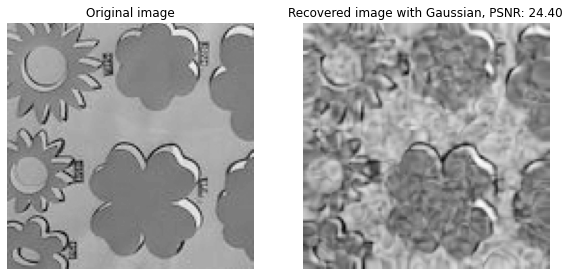

In [16]:
orig_img = img_var.data.cpu().numpy()[0,0]
rec_img = out_img_var.data.cpu().numpy()[0,0]
# orig_img = img_var.data.cpu().numpy()[0]
# rec_img = out_img_var.data.cpu().numpy()[0]

def show(plt, img):
    plt.imshow(img, cmap='gray')
#     plt.imshow(np.transpose(img, (1, 2, 0)))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
show(ax1, orig_img) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
show(ax2, rec_img)
ax2.set_title( "Recovered image with Gaussian, PSNR: %.2f" % psnr(orig_img, rec_img) )
ax2.axis('off') 

print( np.linalg.norm(orig_img /np.linalg.norm(orig_img) - rec_img/np.linalg.norm(rec_img)) )

In [17]:
# define R_omega
img_size = img_var.shape[-1]
measurement_size = np.prod(img_var.shape)

ratio = m / measurement_size # for comparison
tmp = torch.cuda.FloatTensor(1, 1, measurement_size).uniform_() < ratio
tmp = tmp.view(-1, 1, measurement_size)

R_np = var_to_np(tmp).reshape(-1)
R = np_to_var(R_np).type(dtype)
R = R.view(-1)

In [22]:
# define sequence x, t
t = torch.normal(0, 1, size=(measurement_size, 1)).type(dtype)
t = torch.cat((t, torch.zeros(t.shape).type(dtype)), -1)

# random flip: d
d = torch.randint(2, (measurement_size, 1)) * 2 - 1
d = d.reshape(np.prod(d.shape) ).type(dtype)

def forward_circulant(img_var):
    x = img_var.reshape(np.prod(img_var.shape) )
    
    # flip signs
#     x = d * x
    
    Cx = fft_circulant(x, t)
    RCx = R * Cx
    return RCx

forward_circulant(img_var).shape

torch.Size([16384])

In [23]:
num_channels = [256]*5
y = forward_circulant(img_var)

In [24]:
out_img_var, mse_n, mse_t = dd_recovery(y.data, img_var, num_channels, apply_f=forward_circulant)

[(25, 25), (37, 37), (56, 56), (85, 85), (128, 128)]
input shape:  [1, 256, 16, 16]
init norm:  66.10345
orig img norm:  84.075096
optimize with adam 0.005
330496ion 01490    Train loss 0.689463  Actual loss 0.006535 Actual loss orig 0.006535   


0.12405102


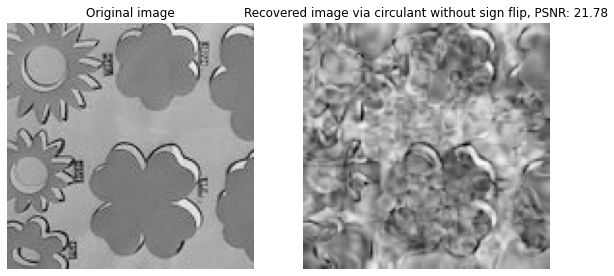

In [25]:
orig_img = img_var.data.cpu().numpy()[0,0]
rec_img = out_img_var.data.cpu().numpy()[0,0]
# orig_img = img_var.data.cpu().numpy()[0]
# rec_img = out_img_var.data.cpu().numpy()[0]

def show(plt, img):
    plt.imshow(img, cmap='gray')
#     plt.imshow(np.transpose(img, (1, 2, 0)))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
show(ax1, orig_img) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
show(ax2, rec_img)
ax2.set_title( "Recovered image via circulant without sign flip, PSNR: %.2f" % psnr(orig_img, rec_img) )
ax2.axis('off') 

print( np.linalg.norm(orig_img /np.linalg.norm(orig_img) - rec_img/np.linalg.norm(rec_img)) )

0.09097199


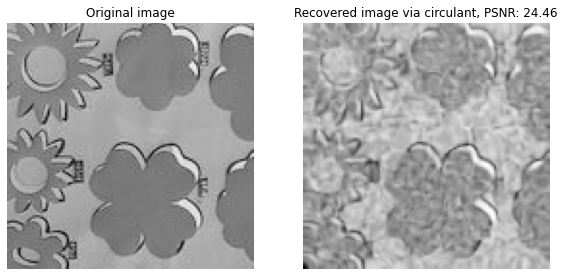

In [21]:
orig_img = img_var.data.cpu().numpy()[0,0]
rec_img = out_img_var.data.cpu().numpy()[0,0]
# orig_img = img_var.data.cpu().numpy()[0]
# rec_img = out_img_var.data.cpu().numpy()[0]

fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
show(ax1, orig_img) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
show(ax2, rec_img)
ax2.set_title( "Recovered image via circulant, PSNR: %.2f" % psnr(orig_img, rec_img) )
ax2.axis('off') 

print( np.linalg.norm(orig_img /np.linalg.norm(orig_img) - rec_img/np.linalg.norm(rec_img)) )